<a href="https://colab.research.google.com/github/hartwj/Twitter/blob/main/Twitter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Twitter Sentiment Analysis

Prior to this assignment, I worked with a partner where we annotated a set of at least 200 microblog posts (Training Set) to create an annotation manual.

Please read the annotation manual in Github for more information. We classifed tweets as either positive, neutral, or negative. `MATCH_MISS` was coded as 1 for tweets we identified similarily and 0 if we annotated differently.


I start by reading in the file, importing packages, and creating some custom functions. This assignment uses a variety of hyperparameters, models, and optimization techniques to produce the best-performing sentiment prediction model. 

In [1]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1lx-xPWiRoyUhIY3B0T0M5brLKRYauPn5' -O Assignment5_Hartwell.csv

--2021-02-28 23:59:52--  https://docs.google.com/uc?export=download&id=1lx-xPWiRoyUhIY3B0T0M5brLKRYauPn5
Resolving docs.google.com (docs.google.com)... 209.85.200.101, 209.85.200.138, 209.85.200.113, ...
Connecting to docs.google.com (docs.google.com)|209.85.200.101|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-10-7k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/5tre6h8j877lltdljfbu0upk1ljv0age/1614556725000/14947468445787936960/*/1lx-xPWiRoyUhIY3B0T0M5brLKRYauPn5?e=download [following]
--2021-02-28 23:59:52--  https://doc-10-7k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/5tre6h8j877lltdljfbu0upk1ljv0age/1614556725000/14947468445787936960/*/1lx-xPWiRoyUhIY3B0T0M5brLKRYauPn5?e=download
Resolving doc-10-7k-docs.googleusercontent.com (doc-10-7k-docs.googleusercontent.com)... 172.253.114.132, 2607:f8b0:4001:c22::84
Connecting to doc-10-7k-docs.googleusercontent.com (doc-10-7k-

In [2]:
import pandas as pd
input_file = pd.read_csv("Assignment5_Hartwell.csv")
print(input_file.shape)
df = pd.read_csv("Assignment5_Hartwell.csv")
df.head()

(200, 5)


,Topic,Tweet,Label_A,Label_B,MATCH_MISS
0,super eagles,@channels_sports Super Eagles performance was ...,-1,-1,1
1,zayn,I'm surprised it took this long after Zayn lef...,0,0,1
2,cate blanchett,"Cate Blanchett isn't a tall poppy, she's a red...",1,0,0
3,milan,@SimonTa49010623 get to Manchester at 7 tonigh...,0,0,1
4,dunkin,My dad just said we can't get Dunkin tomorrow ...,-1,0,0


# Setup and Imports

In [3]:
import math
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib import dates
from datetime import datetime
import re
import calendar
import json

from sklearn.metrics import accuracy_score, precision_score, recall_score, cohen_kappa_score, confusion_matrix, f1_score, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB, ComplementNB, GaussianNB, MultinomialNB 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn import tree
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
"""
Options for noisy: "loud", "quiet", and other. Any other value prints nothing (silent).
"""

# Start by defining a function to evaluate a classifier's predictions
def evaluate(y_pred, y_actual, metrics, model_name = 'model'):
    # Compute Confusion Matrix
    conf_matrix = confusion_matrix(y_actual, y_pred)

    # Compute and store each metric
    model_metrics = {}
    for (metric_name, metric) in metrics.items():
        result = metric(y_actual, y_pred)
        model_metrics[metric_name] = result

    return conf_matrix, model_metrics

# Then define a function that trains a classifier and evaluates it on one fold
def evaluate_one_fold(classifier_name, classifier, X_train, y_train, X_test, y_test, metrics, fold_num, noisy = 'loud', labels=[]):

    # Train and Evaluate Model
    model = classifier.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    conf_matrix, model_metrics = evaluate(y_pred, y_test, metrics, model_name = classifier_name)

    # Display Results appropriately when noisy is set to 'loud' or 'quiet'
    if noisy == 'quiet' and fold_num == 0:
        print(f"{classifier_name}: Fold {fold_num}", end = '')
    elif noisy == 'quiet':
        print(f'...{fold_num}', end ='')
    elif noisy == 'loud':
        print(f"{classifier_name}: Fold {fold_num} Results")
        ConfusionMatrixDisplay(conf_matrix, labels).plot(values_format='.4g')
        plt.show()
        print(model_metrics)
        print("------------------------")

    return model_metrics

# Then define a function to evaluate over all folds
def evaluate_all_folds(classifier_name, classifier, X, y, kf, metrics, noisy = 'loud', labels=[]):

    # Initialize tracking variables
    all_fold_metrics = {metric_name: [] for metric_name in metrics}

    # Iterate over each fold
    for fold_num, (train_index, test_index) in enumerate(kf.split(X, y)):
        # Get the data subset for the current fold
        X_train = X.iloc[train_index]
        X_test = X.iloc[test_index]
        y_train = y.iloc[train_index]
        y_test = y.iloc[test_index]

        # Train and Evaluate the Model
        model_metrics =  evaluate_one_fold(classifier_name, classifier, X_train, y_train, X_test, y_test, metrics, fold_num, noisy, labels=labels)

        # Update our tracking variables
        [all_fold_metrics[metric_name].append(metric_val) for metric_name, metric_val in model_metrics.items()]

    return all_fold_metrics

#Dont worry about these two lines
#@ignore_warnings(category=ConvergenceWarning)
#@ignore_warnings(category=UndefinedMetricWarning)
# Then define a function to compare different classifiers
def compare_classifiers(classifiers, metrics, metric_to_optimize, df, feature_set,
                        target, folds = 10, shuffle = True, noisy='loud', labels=[]):
    # Initialize tracking variables
    best = 0
    best_name = None
    classifier_comparison = {}

    # Set up dataset and cross validation
    X = df.loc[:, feature_set]
    X = pd.get_dummies(X)
    y = df[target]
    kf = StratifiedKFold(n_splits=folds, shuffle=shuffle, random_state=123)


    # For each classifier
    for classifier_name, classifier in classifiers.items():
        # Evaluate on all metrics for all folds
        all_fold_metrics = evaluate_all_folds(classifier_name, classifier, X, y, kf, metrics, noisy = noisy, labels=labels)

        # Compute average performance on metric to optimize over
        optimization_metric_avg = np.mean(all_fold_metrics[metric_to_optimize])

        # Update Tracking Variables
        if optimization_metric_avg > best:
            best = optimization_metric_avg
            best_name = classifier_name
        classifier_comparison[classifier_name] = all_fold_metrics
        if noisy == 'quiet': 
            print()
            print(f"Average {metric_to_optimize}: {optimization_metric_avg:.3f}")
            print('-------------')
    # Return our results
    return best, best_name, classifier_comparison

In [5]:
#re-naming labels

def labels(x):
  if x == -1:
    return "Negative"
  if x== 1: 
    return "Positive"
  if x == 0: 
    return "Neutral"


df["Label_A"] = df["Label_A"].apply(labels)

df.head(5)

,Topic,Tweet,Label_A,Label_B,MATCH_MISS
0,super eagles,@channels_sports Super Eagles performance was ...,Negative,-1,1
1,zayn,I'm surprised it took this long after Zayn lef...,Neutral,0,1
2,cate blanchett,"Cate Blanchett isn't a tall poppy, she's a red...",Positive,0,0
3,milan,@SimonTa49010623 get to Manchester at 7 tonigh...,Neutral,0,1
4,dunkin,My dad just said we can't get Dunkin tomorrow ...,Negative,0,0


In [6]:
df["Label_B"] = df["Label_B"].apply(labels)
df.head()

,Topic,Tweet,Label_A,Label_B,MATCH_MISS
0,super eagles,@channels_sports Super Eagles performance was ...,Negative,Negative,1
1,zayn,I'm surprised it took this long after Zayn lef...,Neutral,Neutral,1
2,cate blanchett,"Cate Blanchett isn't a tall poppy, she's a red...",Positive,Neutral,0
3,milan,@SimonTa49010623 get to Manchester at 7 tonigh...,Neutral,Neutral,1
4,dunkin,My dad just said we can't get Dunkin tomorrow ...,Negative,Neutral,0


# Task 1
I split the data into a training set and a test for an 80%/20% split. With 200 rows, this resulted in 160 observations for the train set and 40 for the test set.

In [7]:
# Solution to Task 1:

#already randomized so train will be based on first 80% of data - 160 rows

test_perc = 0.2
test_set_size = int(len(df)*test_perc)
test_cutoff = len(df) - test_set_size
data_train = df[:test_cutoff]
data_test = df[test_cutoff:]

print("Train set size",len(data_train))
print("Test set size",len(data_test))

Train set size 160
Test set size 40


In [8]:
#Overview of Training Sentiment
data_train["Label_A"].value_counts()/len(data_train)

Positive    0.56875
Negative    0.28750
Neutral     0.14375
Name: Label_A, dtype: float64

In [9]:
#Overview of Testing Sentiment
data_test["Label_A"].value_counts()/len(data_test)

Positive    0.700
Negative    0.225
Neutral     0.075
Name: Label_A, dtype: float64

In [10]:
data_test.head()

,Topic,Tweet,Label_A,Label_B,MATCH_MISS
160,thor,"The name Friday comes from Freya, the goddess ...",Positive,Positive,1
161,david price,Blue Jays win 5th straight behind birthday boy...,Positive,Positive,1
162,iran,"If Iran was ruled by ""rational"" anti-semites, ...",Negative,Neutral,0
163,ed sheeran,"my mom and I may have many differences, but we...",Positive,Positive,1
164,big brother,if John goes home in the double eviction tomor...,Negative,Negative,1


# Task 2

Next I used a 10-fold cross-validation on the training set. Each fold contained 8% of the original training data (each fold containing 16 examples). 

I optimized a machine learning classifier predicting `labels_A`, using features I extracted from the microblog texts. 

I performed the following three optimizations:

   - Compared Naïve Bayes, Logistic Regression, and SVMs on a unigram feature space.
   - Compared a unigram feature space with a feature space that also includes longer N-grams.
   - Varied the vocabulary size of your n-gram feature space and evaluate how performance changes.

Finally I tuned the hyperparameters of my best performing model. 


# Task 2 #1: Compare Naïve Bayes, Logistic Regression, and SVMs on a unigram feature space 

In [12]:
#coverting tweets into bag of words model
vocab_size = 1000

vectorizer = CountVectorizer(max_features=vocab_size)
X = vectorizer.fit_transform(data_train["Tweet"])

for k in list(vectorizer.vocabulary_.keys())[:20]:
  print(f"{k}: {vectorizer.vocabulary_[k]}")

channels_sports: 184
super: 795
eagles: 320
performance: 559
was: 932
amp: 93
disappointing: 300
we: 941
may: 425
not: 498
qualify: 613
if: 377
the: 824
of: 509
africa: 66
doesnt: 311
select: 709
well: 945
surprised: 799
it: 387


In [13]:
#creating a new dataframe
#vocab words will now be columns in the new df
bow_df = pd.DataFrame(X.toarray())
column_names = [str(i) for i in range(vocab_size)]

for k, v in vectorizer.vocabulary_.items():
  column_names[v] = k
bow_df.columns = column_names

bow_df["Label_A"] = data_train["Label_A"].values 

bow_df

,00pm,07,10,11th,12,13th,14,14th,1683,16th,17,18,1963,1jnbgk9rur,1st,1xlupgyqxv,20,2015,20th,21st,22,25,25am,25th,28,2am,2nd,2vzpyetrsm,30,34v0tsvtq0,3rd,46,4th,50,5th,6000,6godolrw3z,6mem3a3ala,7dzryrf2pt,80s,...,winning,wisconsin,wish,wishing,with,woke,woman,women,won,wonder,wondering,work,world,worry,worse,would,wright,writes,writing,wrong,wwe,wy3k6hcqmy,xcash,xi,xlotsoflouisx,xrthxr,y0u,ya,ydwlkf9ue6,years,yes,yet,yiov1brgiw,yoga,you,your,youtube,yuh,zayn,Label_A
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Negative
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,Neutral
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Positive
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Neutral
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Positive
156,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Positive
157,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,Negative
158,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,Neutral


In [14]:
#Use the Unigram BOW dataframe to test the following models:
#Bernoulli NB, Logistic Regression, and Support Vector Machine (SVM)
#Optimize for Kappa

classifiers = {
    "Bernoulli NB": BernoulliNB(),
    "Logistic Regression" : LogisticRegression(),
    "Support Vector Machine": LinearSVC()}

metrics = {
    "Accuracy" : lambda y, y_pred: 100*(accuracy_score(y,y_pred)),
    "Kappa"    : cohen_kappa_score
}

metric_to_optimize = 'Kappa'
bow_features = column_names
feature_set = bow_features
sorted_sentiments = ["Negative", "Netural", "Positive"]
best, best_name, classifier_comparison = compare_classifiers(classifiers, metrics, metric_to_optimize, bow_df, feature_set, "Label_A", labels=sorted_sentiments, noisy = 'quiet')

Bernoulli NB: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: 0.088
-------------
Logistic Regression: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: 0.129
-------------
Support Vector Machine: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: 0.171
-------------


In [15]:
#Optimize for Accuracy
metric_to_optimize = 'Accuracy'
best, best_name, classifier_comparison = compare_classifiers(classifiers, metrics, metric_to_optimize, bow_df, feature_set, "Label_A", labels=sorted_sentiments, noisy = 'quiet')

Bernoulli NB: Fold 0...1...2...3...4...5...6...7...8...9
Average Accuracy: 60.000
-------------
Logistic Regression: Fold 0...1...2...3...4...5...6...7...8...9
Average Accuracy: 58.125
-------------
Support Vector Machine: Fold 0...1...2...3...4...5...6...7...8...9
Average Accuracy: 56.250
-------------


**Results**

Based on the training data of 160 instances (test is the remaining 40 that was held out), the Naive Bayes model had the highest accuracy and the Support Vector Machine had the highest kappa score. I used K-fold cross validation which runs 10 tests of 16 tweets each. Overall these models are pretty weak, but given that textual data is inexact I am pleased with the initial results. 

|Model| Accuracy | Kappa
|-----|----------|------
|Naïve Bayes|60%|0.088
|Logistic Regression|58.12%|0.129
|Support Vector Machine|56.25%|0.171

# Task 2: #2 Compare a unigram feature space with a feature space that also includes longer N-grams

In [16]:
#Ok I'm going to build three new feature spaces
#Bigram, Trigram, and Bi+Trigram

In [17]:
#Building Bigram Dataframe
#Chose to keep vocab size at 1000
vocab_size = 1000

vectorizer = CountVectorizer(max_features=vocab_size,ngram_range=(2,2)) #the magic cell
X = vectorizer.fit_transform(data_train["Tweet"])

for k in list(vectorizer.vocabulary_.keys())[:20]:
  print(f"{k}: {vectorizer.vocabulary_[k]}")


bow_df_bi = pd.DataFrame(X.toarray())
column_names = [str(i) for i in range(vocab_size)]

for k, v in vectorizer.vocabulary_.items():
  column_names[v] = k
bow_df_bi.columns = column_names

bow_df_bi["Label_A"] = data_train["Label_A"].values

bow_df_bi

super eagles: 667
performance was: 400
was lacklustre: 848
we may: 875
may not: 95
not qualify: 243
qualify if: 459
if the: 60
of africa: 268
select well: 603
took this: 743
zayn left: 999
https co: 57
poppy she: 425
she redwood: 629
redwood long: 481
may she: 100
she continue: 625
simonta49010623 get: 645
to manchester: 685


,00pm in,8th grade,and it,and the,and there,ant man,apple tv,as the,at the,be better,be george,be here,be on,be over,be the,bieber tickets,black friday,bond theme,but he,but it,but lets,caitlyn jenner,can believe,can wait,carlos beltran,carly fiorina,charlie hebdo,chuck norris,cream day,david price,david wright,day on,dean ambrose,dog day,enough to,first time,floyd mayweather,for christians,for the,for wednesday,...,yet sharknado3,yet the,yet to,yoga will,you add,you all,you and,you are,you but,you definitely,you didn,you don,you dumb,you going,you guys,you have,you know,you live,you ll,you make,you may,you need,you on,you one,you promise,you re,you say,you see,you were,you will,you wish,your concrete,your monday,your own,your sources,your vigilante,youtube video,yuh kno,zayn left,Label_A
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Negative
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,Neutral
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Positive
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Neutral
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Positive
156,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Positive
157,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Negative
158,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Neutral


In [18]:
#Trigram Dataframe
vocab_size = 1000

vectorizer = CountVectorizer(max_features=vocab_size,ngram_range=(3,3)) #trigrams
X = vectorizer.fit_transform(data_train["Tweet"])

for k in list(vectorizer.vocabulary_.keys())[:20]:
  print(f"{k}: {vectorizer.vocabulary_[k]}")


bow_df_tri = pd.DataFrame(X.toarray())
column_names = [str(i) for i in range(vocab_size)]

for k, v in vectorizer.vocabulary_.items():
  column_names[v] = k
bow_df_tri.columns = column_names

bow_df_tri["Label_A"] = data_train["Label_A"].values

#look at it#
bow_df_tri

performance was lacklustre: 380
was lacklustre amp: 843
we may not: 868
may not qualify: 60
not qualify if: 206
qualify if the: 437
of africa doesnt: 230
took this long: 731
zayn left for: 999
poppy she redwood: 404
she redwood long: 617
redwood long may: 462
may she continue: 66
she continue to: 614
simonta49010623 get to: 633
manchester at tonight: 30
tonight just sat: 721
just sat in: 12
sat in milan: 543
milan airport now: 92


,00pm in gsc,be george osborne,be the best,david price may,gov scott walker,he may be,he wanted to,ice cream day,if you re,in the http,is going to,is singing the,just sat in,justin bieber tickets,liked youtube video,madrid placed my,maiden may be,maiden single speed,maiden version is,make fun of,make statement on,make sure to,make their entrance,make your own,makes sense you,making caitlyn jenner,malenko review connecticut,man amp suddenly,man utd with,man who john,manchester at tonight,manchester the clear,manchester united real,many videos going,marriage gender trends,married prince george,match thine distinctive,may allah bless,may be 30,may be as,...,you and is,you are interested,you but doing,you definitely should,you didn know,you don believe,you don want,you dumb bitches,you going over,you guys will,you have an,you know kim,you know that,you live in,you ll care,you make fun,you may be,you may have,you may want,you need me,you on saturday,you one of,you promise to,you re getting,you re going,you re my,you say thursday,you see seth,you were wondering,you will need,you wish to,your concrete inpouring,your monday with,your own sundae,your sources if,your vigilante he,youtube video http,yuh kno keep,zayn left for,Label_A
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Negative
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,Neutral
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Positive
3,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Neutral
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Positive
156,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Positive
157,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Negative
158,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Neutral


In [19]:
vocab_size = 1000

vectorizer = CountVectorizer(max_features=vocab_size,ngram_range=(2,3)) #bis and tris
X = vectorizer.fit_transform(data_train["Tweet"])

for k in list(vectorizer.vocabulary_.keys())[:20]:
  print(f"{k}: {vectorizer.vocabulary_[k]}")


bow_df_bitri = pd.DataFrame(X.toarray())
column_names = [str(i) for i in range(vocab_size)]

for k, v in vectorizer.vocabulary_.items():
  column_names[v] = k
bow_df_bitri.columns = column_names

bow_df_bitri["Label_A"] = data_train["Label_A"].values

#look at it#
bow_df_bitri

super eagles: 947
performance was: 378
we may: 985
may not: 155
qualify if: 494
if the: 67
select well: 793
performance was lacklustre: 379
may not qualify: 157
qualify if the: 495
https co: 63
poppy she: 427
she redwood: 844
redwood long: 541
may she: 167
she continue: 837
poppy she redwood: 428
she redwood long: 845
redwood long may: 542
may she continue: 168


,00pm in,8th grade,and it,and the,and there,ant man,apple tv,as the,at the,be better,be george,be george osborne,be here,be on,be over,be the,be the best,bieber tickets,black friday,bond theme,but he,but it,but lets,caitlyn jenner,can believe,can wait,carlos beltran,carly fiorina,charlie hebdo,chuck norris,cream day,david price,david price may,david wright,day on,dean ambrose,dog day,enough to,first time,floyd mayweather,...,the same,the way,they have,to be,to buy,to nirvana,to nirvana at,to see,to the,to watch,tomorrow morning,tomorrow so,tomorrow will,tomorrow will be,tonight but,under the,up and,ve seen,video http,video http co,walker may,want to,wanted to,was born,we may,were wondering,will be,with my,with the,with two,with us,won be,you all,you don,you know,you may,you re,youtube video,youtube video http,Label_A
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Negative
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Neutral
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Positive
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Neutral
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Positive
156,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Positive
157,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Negative
158,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Neutral


In [20]:
#I toggled the names of the n gram dataframes on the last line to get results
#sometimes it would break and I'd have to change the name of the DF

classifiers = {
    "Bernoulli NB": BernoulliNB(),
    "Logistic Regression": LogisticRegression(),
    "Support Vector Machine": LinearSVC()}

metrics = {
    "Accuracy" : lambda y, y_pred: 100*(accuracy_score(y,y_pred)),
    "Kappa"    : cohen_kappa_score
}

metric_to_optimize = 'Accuracy'
bow_features = column_names
feature_set = bow_features
sorted_sentiments = ["Negative", "Netural", "Positive"]
best, best_name, classifier_comparison = compare_classifiers(classifiers, metrics, metric_to_optimize, bow_df_bitri, feature_set,"Label_A", labels=sorted_sentiments, noisy = 'quiet')


Bernoulli NB: Fold 0...1...2...3...4...5...6...7...8...9
Average Accuracy: 56.875
-------------
Logistic Regression: Fold 0...1...2...3...4...5...6...7...8...9
Average Accuracy: 55.000
-------------
Support Vector Machine: Fold 0...1...2...3...4...5...6...7...8...9
Average Accuracy: 51.875
-------------


The most accurate model came from the Unigrams that we used in Part1 #1 at 60% with Naive Bayes. SVMs showed some improvement in accuracy with trigrams. The highest kappa scores came from the original unigram model. 

Unigram Model: 

|Model| Accuracy | Kappa
|-----|----------|------
|Naïve Bayes|60%|0.088
|Logistic Regression|58.12%|0.129
|Support Vector Machine|56.25%|0.171

Bigram Model:

|Model| Accuracy | Kappa
|-----|----------|------
|Naïve Bayes|56.8%|0.0
|Logistic Regression|55.6%|0.017
|Support Vector Machine|55%|0.046

Trigram Model:

|Model| Accuracy | Kappa
|-----|----------|------
|Naïve Bayes|56.8%|0.0
|Logistic Regression|56.8%|0.0
|Support Vector Machine|56.8%|0.01

Bigram and Trigram Model: 

|Model| Accuracy | Kappa
|-----|----------|------
|Naïve Bayes|56.8%|0.0
|Logistic Regression|55%|0.007
|Support Vector Machine|51%|0.046

# Task 2: #3 Vary the vocabulary size of your n-gram feature space and evaluate how performance changes

In [21]:
#I'm going to use vocab sizes from 250-1250 with 250 word steps
#The next sections of code were toggled to get results
vocab_size = 250

vectorizer = CountVectorizer(max_features=vocab_size)
X = vectorizer.fit_transform(data_train["Tweet"])

for k in list(vectorizer.vocabulary_.keys())[:20]:
  print(f"{k}: {vectorizer.vocabulary_[k]}")

super: 201
eagles: 50
was: 231
amp: 10
we: 234
may: 123
not: 148
if: 85
the: 204
of: 151
well: 236
it: 91
this: 210
long: 113
after: 5
zayn: 249
left: 105
for: 62
to: 215
https: 83


In [22]:
#Building the DF
bow_df_size = pd.DataFrame(X.toarray())
column_names = [str(i) for i in range(vocab_size)]

for k, v in vectorizer.vocabulary_.items():
  column_names[v] = k
bow_df_size.columns = column_names

bow_df_size["Label_A"] = data_train["Label_A"].values

bow_df_size

,1st,2nd,30,9th,about,after,against,album,all,am,amp,an,and,are,as,at,back,be,been,before,believe,best,bieber,black,but,by,can,cause,cena,christians,christmas,co,come,cream,cube,dark,david,day,days,dead,...,thor,thursday,tickets,time,to,today,tomorrow,tonight,too,toy,tuesday,two,under,up,us,ve,vs,walker,want,wanted,was,watch,way,we,wednesday,well,were,what,when,who,why,will,with,world,wwe,yet,you,your,zayn,Label_A
0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,Negative
1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,Neutral
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Positive
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Neutral
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,Negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Positive
156,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Positive
157,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,Negative
158,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,Neutral


In [23]:
#Evaluating the 3 models
classifiers = {
    "Bernoulli NB": BernoulliNB(),
    "Logistic Regression" : LogisticRegression(),
    "Support Vector Machine": LinearSVC()}

metrics = {
    "Accuracy" : lambda y, y_pred: 100*(accuracy_score(y,y_pred)),
    "Kappa"    : cohen_kappa_score
}

metric_to_optimize = 'Accuracy'
bow_features = column_names
feature_set = bow_features
sorted_sentiments = ["Negative", "Netural", "Positive"]
best, best_name, classifier_comparison = compare_classifiers(classifiers, metrics, metric_to_optimize, bow_df_size, feature_set, "Label_A", labels=sorted_sentiments, noisy = 'quiet')


Bernoulli NB: Fold 0...1...2...3...4...5...6...7...8...9
Average Accuracy: 59.375
-------------
Logistic Regression: Fold 0...1...2...3...4...5...6...7...8...9
Average Accuracy: 56.250
-------------
Support Vector Machine: Fold 0...1...2...3...4...5...6...7...8...9
Average Accuracy: 51.250
-------------


The Naive Bayes models seemed to perform the best based on accuracy and kappa. The best results were using a dataframe with a vocabulary size of 500. This resulted in 63% accuracy and a kappa of .219

**Vocab Size = 250**:

| Model | Accuracy | Kappa
|-------|----------|------
|Naive Bayes| 59.37| .196
|Logistic Regression| 56.25| .146
|Support Vector Machine|51.25| .144

**Vocab Size = 500**: 

| Model | Accuracy | Kappa
|-------|----------|------
|Naive Bayes| 63.12| .219
|Logistic Regression| 58.12| .183
|Support Vector Machine|55| .182

**Vocab Size = 750**: 

| Model | Accuracy | Kappa
|-------|----------|------
|Naive Bayes| 60| .118
|Logistic Regression| 57.5| .131
|Support Vector Machine|55| .162

**Vocab Size = 1000**:


| Model | Accuracy | Kappa
|-------|----------|------
|Naive Bayes| 60| .088
|Logistic Regression| 58.12| .129
|Support Vector Machine|56.25| .171

**Vocab Size = 1250**: 

| Model | Accuracy | Kappa
|-------|----------|------
|Naive Bayes| 56.87| .0
|Logistic Regression| 57.5| .01
|Support Vector Machine|56.25| .15

# Task 2: Tuning the Best Model with Hyperparameters

I chose the SVM model because it showed promising kappas and the hyperparamater tuning seemed simpler than Naive Bayes. 

I included both unigrams and bigrams in the new data frame. Vocabulary size was set at 750 and I included stop words. 

The three classifiers are now SVM, Polynomial SVM, and Radial Basis Function SVM.

In [24]:
#new data frame

vocab_size = 750

vectorizer = CountVectorizer(max_features=vocab_size,ngram_range=(1,2,), stop_words='english')
X = vectorizer.fit_transform(data_train["Tweet"])

for k in list(vectorizer.vocabulary_.keys())[:20]:
  print(f"{k}: {vectorizer.vocabulary_[k]}")


bow_hyper = pd.DataFrame(X.toarray())
column_names = [str(i) for i in range(vocab_size)]

for k, v in vectorizer.vocabulary_.items():
  column_names[v] = k
bow_hyper.columns = column_names

bow_hyper["Label_A"] = data_train["Label_A"].values

bow_hyper

super: 691
eagles: 90
performance: 465
amp: 16
qualify: 575
super eagles: 692
performance lacklustre: 466
qualify guardiola: 576
long: 238
zayn: 749
left: 182
https: 133
long zayn: 240
left happen: 183
isn: 142
poppy: 513
redwood: 608
continue: 64
poppy redwood: 514
redwood long: 609


,10,12,13th,1st,2nd,30,4th,8th,8th grade,9th,action,afternoon,album,aldean,ambrose,america,amp,ant,ant man,apple,apple tv,august,bad,beat,begin,believe,beltran,best,better,bieber,bieber tickets,big,black,black friday,bond,bond theme,booed,book,border,born,...,tomorrow ll,tomorrow morning,tonight,towns,toy,tuesday,tv,twilight,u2,ve,ve seen,version,video,video http,vs,wait,walker,want,wanted,war,watch,watched,watchman,way,wednesday,weight,white,wisconsin,wish,woman,won,wonder,wondering,world,wright,wwe,youtube,youtube video,zayn,Label_A
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Negative
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,Neutral
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Positive
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Neutral
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Positive
156,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Positive
157,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Negative
158,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Neutral


In [25]:
#Toggled this code to get full accuracy and kappa results

classifiers = {
    "Support Vector Machine": LinearSVC(),
    "Polynomial SVM": SVC(kernel='poly'),
    "Radial Basis Function SVM": SVC(kernel='rbf')}

metrics = {
    "Accuracy" : lambda y, y_pred: 100*(accuracy_score(y,y_pred)),
    "Kappa"    : cohen_kappa_score
}

metric_to_optimize = 'Kappa'
bow_features = column_names
feature_set = bow_features
sorted_sentiments = ["Negative", "Netural", "Positive"]
best, best_name, classifier_comparison = compare_classifiers(classifiers, metrics, metric_to_optimize, bow_hyper, feature_set, "Label_A", labels=sorted_sentiments, noisy = 'quiet')


Support Vector Machine: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: 0.315
-------------
Polynomial SVM: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: 0.000
-------------
Radial Basis Function SVM: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: 0.000
-------------


**Results**

The best performing by accuracy and kappa was the base linear SVM model at 63% accuracy and a kappa of .315. This is our best model so far today. 

|Model|Accuracy|Kappa|
|-----|--------|-----|
|Linear|63.12%|.315|
|Polynomial|56.87%|0|
|Radial Basis Function|56.87%|0|

# Task 3

For Task 3, I trained two models, each trained on the full 80% training set, and tested on the held-out 20% test set:
   - A Naïve Bayes classifier with unigram features.
   - The best-tuned model from task two, retrained on the full 80% training set. 
   
Then I reported three sets of evaluation metrics:
   - The estimated performance from cross-validation in Task 2.
   - The performance of the simple Naïve Bayes unigram classifier on the held-out test set.
   - The performance of the best-tuned model on the held-out test set.


# Task 3: Naive Bayes

In [27]:
#Train Data
#building a feature space with vocab size of 385

vocab_size = 385

vectorizer = CountVectorizer(max_features=vocab_size)
X = vectorizer.fit_transform(data_train["Tweet"])

for k in list(vectorizer.vocabulary_.keys())[:20]:
  print(f"{k}: {vectorizer.vocabulary_[k]}")


bow_NB = pd.DataFrame(X.toarray())
column_names = [str(i) for i in range(vocab_size)]

for k, v in vectorizer.vocabulary_.items():
  column_names[v] = k
bow_NB.columns = column_names

bow_NB["Label_A"] = data_train["Label_A"].values

bow_NB

super: 305
eagles: 89
was: 359
amp: 17
we: 364
may: 194
not: 221
if: 146
the: 315
of: 224
well: 367
it: 156
this: 324
long: 184
after: 7
zayn: 384
left: 175
for: 106
to: 331
https: 144


,1st,2nd,30,8th,9th,about,action,after,afternoon,against,album,aldean,all,almost,am,ambrose,america,amp,an,and,another,ant,apple,are,as,at,august,back,bad,be,beat,been,before,begin,believe,beltran,best,better,bieber,big,...,up,us,ve,version,very,via,video,vs,wait,walker,want,wanted,war,was,watch,watched,watchman,way,we,wednesday,weight,well,were,what,when,while,white,who,why,will,wisconsin,wish,with,world,wwe,yet,you,your,zayn,Label_A
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Negative
1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,Neutral
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Positive
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Neutral
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,Negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Positive
156,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Positive
157,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,Negative
158,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,Neutral


In [28]:
#Test Data

vocab_size = 385


vectorizer = CountVectorizer(max_features=vocab_size,stop_words='english')
X = vectorizer.fit_transform(data_test["Tweet"])

for k in list(vectorizer.vocabulary_.keys())[:20]:
  print(f"{k}: {vectorizer.vocabulary_[k]}")


bow_NB_test = pd.DataFrame(X.toarray())
column_names = [str(i) for i in range(vocab_size)]

for k, v in vectorizer.vocabulary_.items():
  column_names[v] = k
bow_NB_test.columns = column_names

bow_NB_test["Label_A"] = data_test["Label_A"].values

bow_NB_test

friday: 128
comes: 70
freya: 127
goddess: 141
love: 210
fertility: 115
black: 40
cats: 57
gift: 138
thor: 334
god: 140
thunder: 335
blue: 41
jays: 179
win: 371
5th: 5
straight: 320
birthday: 38
boy: 42
david: 81


,15,18,1st,20,24,5th,6th,9th,a71vosgjjq,aaaaah,abortionist,aepiqxrkoq,agree,album,allen,alllivesmatter,amberpowerss6,amp,ankles,ant,anti,appearance,assassination,atheist,away,awesome,axe,baby,badotweet,band,bandana,bar,bc,better,bieber,big,billion,binnie,birthday,bit,...,u2,ugly,ujjwal,ujlwhhk92m,uk,united,unlike,used,utter,uvuv7vvnts,venice,vote,wa,walks,wanna,want,washington,wasn,waste,watching,week,weeknd,west,wheels,white,win,woman,word,working,world,worried,worst,wright,wstnlkecn7,xkbar1k1zk,ya,yakub,york,zac,Label_A
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Positive
1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,Positive
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Negative
3,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Positive
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,Negative
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Positive
6,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Positive
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Positive
8,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Positive
9,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Positive


In [29]:
#Creating the NB classifier and testing on held out data
X_trainNB = bow_NB.iloc[:,:-1]
X_trainNB = pd.get_dummies(X_trainNB)
y_trainNB = bow_NB["Label_A"]

X_testNB = bow_NB_test.iloc[:,:-1]
y_testNB = bow_NB_test["Label_A"]

model_NB = BernoulliNB().fit(X_trainNB, y_trainNB)
y_predNB = model_NB.predict(X_testNB)

AccuracyNB = accuracy_score(y_predNB,y_testNB)
KappaNB = cohen_kappa_score(y_predNB,y_testNB)

print(f"Accuracy of the unigram Naive Bayes is {AccuracyNB: 3f} ")
print(f"Kappa of the unigram Naive Bayes is {KappaNB: 3f}")

Accuracy of the unigram Naive Bayes is  0.600000 
Kappa of the unigram Naive Bayes is  0.025875


# Task 3: The Best Tuned Model from Task 2

In [30]:
#copying code from best model used earlier

vocab_size = 750

vectorizer = CountVectorizer(max_features=vocab_size,ngram_range=(1,2,), stop_words='english', )
X = vectorizer.fit_transform(data_train["Tweet"])

for k in list(vectorizer.vocabulary_.keys())[:20]:
  print(f"{k}: {vectorizer.vocabulary_[k]}")


bow_train_final_df = pd.DataFrame(X.toarray())
column_names = [str(i) for i in range(vocab_size)]

for k, v in vectorizer.vocabulary_.items():
  column_names[v] = k
bow_train_final_df.columns = column_names

bow_train_final_df["Label_A"] = data_train["Label_A"].values

bow_train_final_df

super: 691
eagles: 90
performance: 465
amp: 16
qualify: 575
super eagles: 692
performance lacklustre: 466
qualify guardiola: 576
long: 238
zayn: 749
left: 182
https: 133
long zayn: 240
left happen: 183
isn: 142
poppy: 513
redwood: 608
continue: 64
poppy redwood: 514
redwood long: 609


,10,12,13th,1st,2nd,30,4th,8th,8th grade,9th,action,afternoon,album,aldean,ambrose,america,amp,ant,ant man,apple,apple tv,august,bad,beat,begin,believe,beltran,best,better,bieber,bieber tickets,big,black,black friday,bond,bond theme,booed,book,border,born,...,tomorrow ll,tomorrow morning,tonight,towns,toy,tuesday,tv,twilight,u2,ve,ve seen,version,video,video http,vs,wait,walker,want,wanted,war,watch,watched,watchman,way,wednesday,weight,white,wisconsin,wish,woman,won,wonder,wondering,world,wright,wwe,youtube,youtube video,zayn,Label_A
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Negative
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,Neutral
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Positive
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Neutral
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Positive
156,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Positive
157,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Negative
158,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Neutral


In [31]:
#recreating a feature space with unigrams and bigrams

vocab_size = 750

vectorizer = CountVectorizer(max_features=vocab_size,ngram_range=(1,2,), stop_words='english')
X = vectorizer.fit_transform(data_test["Tweet"])

for k in list(vectorizer.vocabulary_.keys())[:20]:
  print(f"{k}: {vectorizer.vocabulary_[k]}")


bow_Tfinal_df = pd.DataFrame(X.toarray())
column_names = [str(i) for i in range(vocab_size)]

for k, v in vectorizer.vocabulary_.items():
  column_names[v] = k
bow_Tfinal_df.columns = column_names

bow_Tfinal_df["Label_A"] = data_test["Label_A"].values

bow_Tfinal_df.head(5)

friday: 247
comes: 142
freya: 244
love: 376
black: 81
cats: 116
thor: 644
thunder: 646
comes freya: 144
freya goddess: 246
love fertility: 377
fertility freya: 219
freya black: 245
black cats: 82
cats gift: 117
thor god: 645
blue: 83
jays: 314
win: 723
5th: 11


,15,15 october,18,18 curtis,1st,1st half,1st time,20,20 walks,24,24 december,5th,5th straight,6th,6th straight,9th,9th birthday,a71vosgjjq,aaaaah,aaaaah word,abortionist,abortionist amp,aepiqxrkoq,agree,agree comes,album,album saturday,album song,allen,allen 1st,alllivesmatter,amberpowerss6,amberpowerss6 sun,amp,amp anti,amp felt,amp snoop,ankles,ankles happy,ant,...,waste feed,watching,watching play,week,week away,weeknd,west,west ankles,west https,wheels,white,white 6th,win,win 5th,woman,woman idiot,word,word emu,working,working album,world,world leaders,worried,worried bit,worst,worst season,wright,wright 20,wstnlkecn7,xkbar1k1zk,xkbar1k1zk badotweet,ya,ya real,yakub,yakub death,yakub innocent,york,york city,zac,Label_A
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Positive
1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Positive
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Negative
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Positive
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,Negative


Kappa Score is 0.005917
Accuracy is 0.475000
Precision Score is 0.475


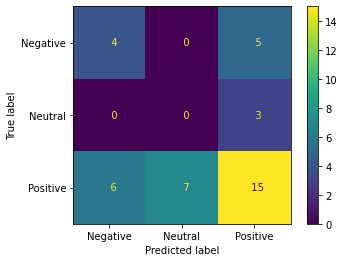

In [32]:
#Introducing the k folds and SKlearn
#Tuned Linear SVM

X_trainFINAL= bow_train_final_df.iloc[:,:-1]
X_trainFINAL=pd.get_dummies(X_trainFINAL)
y_trainFINAL=bow_train_final_df["Label_A"]


Model = LinearSVC().fit(X_trainFINAL,y_trainFINAL)

X_testFINAL=bow_Tfinal_df.iloc[:,:-1]
X_testFINAL=pd.get_dummies(X_testFINAL)

y_testFINAL=bow_Tfinal_df["Label_A"]

y_predFINAL = Model.predict(X_testFINAL)




Accuracy = accuracy_score(y_testFINAL,y_predFINAL)
Kappa = cohen_kappa_score(y_testFINAL,y_predFINAL)
Precision = precision_score(y_testFINAL,y_predFINAL, average='micro')
cmatrix = confusion_matrix(y_testFINAL,y_predFINAL)
print(f"Kappa Score is {Kappa:2f}")
print(f"Accuracy is {Accuracy:2f}")
print(f"Precision Score is {Precision:}")
ConfusionMatrixDisplay(cmatrix,["Negative", "Neutral", "Positive"]).plot(values_format = '4g')
plt.show()

# Results

The Tuned Linear SVM's performance dropped a lot when evaluating the test data. The best performing model was the base SVM, with unigram Naive Baye's 2nd. 


|Model|Accuracy|Kappa
|-----|--------|-----
|Estimated Performance SVM| 63.12%| .315
|Unigram Naive Bayes| 60%| .025
|Tuned Linear SVM (Best Model on held out set)|47.5%|.005
